In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import george
import scipy.stats
import emcee
import h5py
import corner

Let's import our simulated data. 

In [23]:
def read_data(filename, whitespace=False, datadir="./", error=True):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=whitespace)

    tsample = data[0]

    fsample = data[1]
    if error:
        flux_err = data[2]

        return tsample, fsample, flux_err
    
    else:
        return tsample, fsample

In [116]:
time, flux= read_data("../data/paper_plots/221/221_lc_49627_to_49787.txt", whitespace=True, error=False)

Every index is 30 seconds. So let's say we wanted to compare the lightcurve from the first night against a lightcurve 2 months later. 

$$1 \;months = 30 \;days$$
$$1 \; day = 24 \; hours$$
$$1 \; hour = 120 \; thirty-second \; increments$$

$$2 \; months = 60 \; days = 1440 \; hours = 172,800 \; indicies$$

$$6 \; months = 180 \; days = 4320 \; hours = 518,400 \; indicies$$

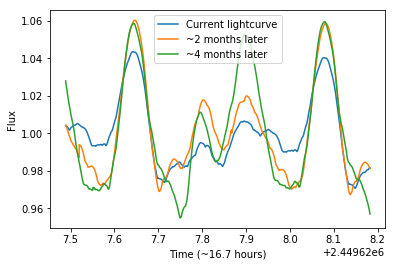

In [117]:
x=110 #fine-tuning the peaks to line up
plt.plot(time[0:2000], flux[0:2000], label="Current lightcurve")
plt.plot(time[0:2000], flux[172800+x:174800+x], label = "~2 months later")
plt.plot(time[0:2000], flux[172800*2+x*2:173800*2+x*2], label = "~4 months later")
plt.xlabel("Time (~%.1f hours)" %((time[2000]-time[0])*24.))
plt.ylabel("Flux")
plt.legend()

As we can see, the rotational period looks to be about the same, but the profile looks quite a bit different when shifting from 0->2->4 months. We want to see if we can modify the kernel to incorporate these long-term changes using the ExpSquared kernel.

Next, we'll import some data that was sampled twice per night over 59 days (~2 months).

In [24]:
time, flux, flux_err = read_data("../data/paper_plots/221/ztf-lsst/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days.txt", whitespace=False)

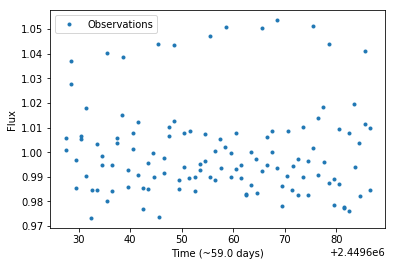

In [120]:
plt.plot(time,flux, ".", label="Observations")
plt.xlabel("Time (~%.1f days)" %(time[time.index.max()]-time[0]))
plt.ylabel("Flux")
plt.legend()

Let's set up a kernel to fit this data to.

In [121]:
np.log(flux.max()-flux.min())

-2.522495157227649

In [25]:
"""Calculates initial gp parameter values based on data."""
# k1 = ExpSquared
amp_1 =0.01
metric = 1000

# k2 = ExpSine2
amp_2 = 0.1#max(flux)-min(flux)
log_period = np.log(6/24.)
gamma = 5


k1 = amp_1 * george.kernels.ExpSquaredKernel(metric=metric)
k2 = amp_2 * george.kernels.ExpSine2Kernel(gamma=gamma, log_period=log_period)

kernel = k1*k2

gp = george.GP(kernel, mean=np.mean(flux), fit_mean=True)

gp.compute(time, flux_err)
pred, pred_var = gp.predict(flux, np.linspace(time[0], time[len(time)-1], 10000), return_var=True)
ln_likelihood = gp.log_likelihood(flux)

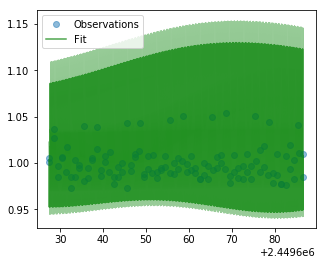

In [123]:
plt.figure(figsize=(5, 4))
plt.plot(time, flux, 'o', alpha=0.5, label="Observations")

#plot the kernel-fitted guess
plt.fill_between(np.linspace(time[0], time[len(time)-1], 10000), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="green", alpha=0.4)
plt.plot(np.linspace(time[0], time[len(time)-1], 10000), pred, 'g', lw=1.5, alpha=0.7, label="Fit")

plt.legend()

Let's try to optimize these parameters.

In [124]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    try:
        negloglike =  -gp.log_likelihood(flux)
        return negloglike
    except scipy.linalg.LinAlgError:
        return np.inf
#print(neg_ln_like)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    try:
        grad_loglike =  -gp.grad_log_likelihood(flux)
        return grad_loglike
    except scipy.linalg.LinAlgError:
        return np.inf
    #return -gp.grad_log_likelihood(y)

In [125]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like) #, method='L-BFGS-B')
gp.set_parameter_vector(result.x)

ln_likelihood_opt = gp.log_likelihood(flux)

print(ln_likelihood, result, ln_likelihood_opt)

-4697.3178856331915       fun: -309.2628194110408
 hess_inv: array([[ 2.81730510e-06, -7.31846287e-08,  8.04565635e-07,
        -7.31846287e-08, -2.92676053e-07,  6.86379301e-09],
       [-7.31846287e-08,  5.04347948e-01,  5.71152290e-03,
        -4.95652052e-01, -2.07767830e-03,  2.73841106e-06],
       [ 8.04565635e-07,  5.71152290e-03,  2.19539919e-01,
         5.71152290e-03,  2.83907635e-01,  8.67487208e-04],
       [-7.31846287e-08, -4.95652052e-01,  5.71152290e-03,
         5.04347948e-01, -2.07767830e-03,  2.73841106e-06],
       [-2.92676053e-07, -2.07767830e-03,  2.83907635e-01,
        -2.07767830e-03,  8.96723037e-01, -3.66980565e-04],
       [ 6.86379301e-09,  2.73841106e-06,  8.67487208e-04,
         2.73841106e-06, -3.66980565e-04,  1.57714828e-05]])
      jac: array([ 2.13185444e-06, -8.80612173e-07, -0.00000000e+00, -8.80612173e-07,
       -0.00000000e+00, -0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 53
      nit: 19
     njev: 53
   

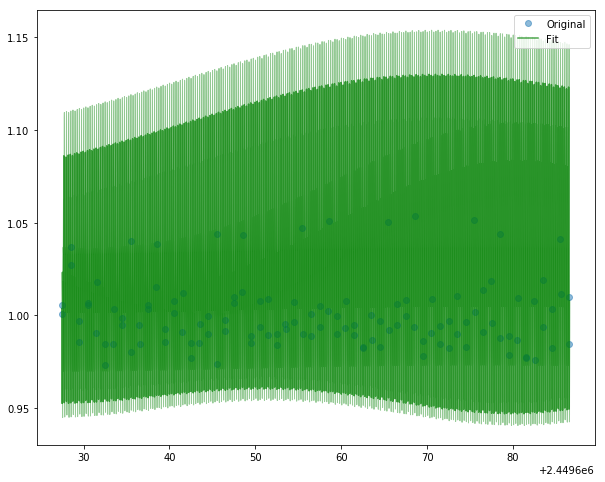

In [126]:
plt.figure(figsize=(10, 8))
plt.plot(time, flux, 'o', alpha=0.5, label="Original")
#plt.plot(x,y, 'ko', ms = 3, alpha=0.5, label="Sample")

#plot the kernel-fitted guess
plt.fill_between(np.linspace(time[0], time[len(time)-1], 10000), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="green", alpha=0.4)
plt.plot(np.linspace(time[0], time[len(time)-1], 10000), pred, 'g', lw=1.5, alpha=0.7, label="Fit")

plt.legend()

Alright, so, even after optimizing the fit with scipy, the fit still looks kinda shitty. I'm gonna set up an MCMC process and see what happens.

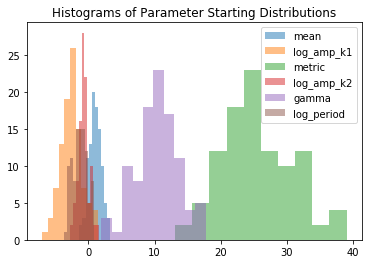

In [13]:
nwalkers = 100

# set up a bunch of kernel starting parameters

mean_flux = np.mean(flux)

# k1
log_amp_k1 = np.log(flux.max()-flux.min())
metric = 5**2

# k2
log_amp_k2 = np.log(0.5)
gamma = 10
log_period = np.log(6/24.)
    

params = {"mean": mean_flux, "log_amp_k1": log_amp_k1, "metric": metric, 
          "log_amp_k2": log_amp_k2, "gamma": gamma,"log_period": log_period}

# Creates a matrix of starting parameters for every walker.
p_start = np.array(list(params.values()))
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=p_start, cov=cov_matrix, size=(nwalkers))

for i in np.arange(len(params)):
    
    plt.hist(p0.T[i], alpha=0.5, label=list(params.keys())[i])
    plt.title("Histograms of Parameter Starting Distributions")
    plt.legend()

# equally distributed starting period values for
p0[:,-1] = np.random.normal(size=nwalkers)*0.5 + np.log(4/24.)

walker_params = p0

"""Calculates initial gp parameter values based on data."""
k1 = np.exp(log_amp_k1) * george.kernels.ExpSquaredKernel(metric=metric)
k2 = np.exp(log_amp_k2) * george.kernels.ExpSine2Kernel(gamma=gamma, log_period=log_period)

kernel = k1*k2

gp = george.GP(kernel, mean=np.mean(flux), fit_mean=True)

gp.compute(time, flux_err)

We also quickly need to define our priors and how we're evaluating the likelihood.

In [3]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    'mean:value',

    'kernel:k1:k1:log_constant',

    'kernel:k1:k2:metric:log_M_0_0',

    'kernel:k2:k1:log_constant',

    'kernel:k2:k2:gamma',

    'kernel:k2:k2:log_period')

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(17, 0.5).logpdf(params[0])
    p_log_amp_k1 = scipy.stats.norm(np.log(2), np.log(10)).logpdf(params[1])
    p_log_metric = scipy.stats.norm(np.log(100), np.log(10)).logpdf(np.log(params[2]))

    p_log_amp_k2 = scipy.stats.norm(np.log(2), np.log(2)).logpdf(params[3])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[4]))
    p_log_period = scipy.stats.norm(np.log(4./24.), (12./24.)).logpdf(params[5])


    sum_log_prior =  p_mean + p_log_amp_k1 + p_log_metric + p_log_amp_k2 + p_log_gamma + p_log_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior


def logl(params, gp, tsample, fsample, flux_err):
     # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)


    try:
        gp.compute(tsample, flux_err)
        lnlike = gp.lnlikelihood(fsample)
    except np.linalg.LinAlgError:
        lnlike = -1e25

    return lnlike


def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25



Now that we have set up the kernel with a variety of starting parameter values, we can start the MCMC run.

In [15]:
ndim = 6
threads = 4
iterations = 1000
burn_in=1000

print("Burn-in starting.")

sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, time, flux, flux_err])

#run steps for a burn-in
state = sampler.run_mcmc(walker_params, burn_in)
sampler.reset()

print("Burn-in complete.")
print("Starting run.")
#print(state[0])
data = sampler.run_mcmc(state[0], iterations)
print("Run complete.")

Burn-in starting.


/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


Burn-in complete.
Starting run.
Run complete.


Hopefully, our data has finished running. Let's save our data and then try plotting this stuff.

In [16]:
with h5py.File("221_k1*k2_test" + ".hdf5", "w") as f:
    f.create_dataset("chain", data=sampler.chain)

    f.attrs['walkers'] = nwalkers
    f.attrs['iterations'] = 1000 #niter
    f.attrs['data_pts'] = len(flux)
    f.attrs['acceptance_fraction'] = sampler.acceptance_fraction
    #f.attrs['burn_in'] = burn_in
    f.create_dataset("time", data= time)
    f.create_dataset("flux", data = flux)
    f.create_dataset("flux_err", data = flux_err)

In [17]:
data = sampler.chain

In [20]:
data[:,:,-1]

array([[20.88146203, 20.88146203, 20.88146203, ..., 20.88241047,
        20.88241047, 20.88241047],
       [10.44038774, 10.44038774, 10.44038774, ..., 10.44027074,
        10.44027074, 10.44027074],
       [20.88095433, 20.88095433, 20.88095433, ..., 20.8786015 ,
        20.8786015 , 20.87954163],
       ...,
       [10.43989113, 10.43989113, 10.43989113, ..., 10.44057445,
        10.44057445, 10.44057445],
       [18.46186436, 18.46186436, 18.46186436, ..., 18.46059862,
        18.46059862, 18.46059862],
       [20.88128482, 20.88128482, 20.88128482, ..., 20.8809849 ,
        20.8809849 , 20.8809849 ]])

In [19]:
data[:,:,-1] = np.exp(sampler.chain[:,:,-1])*24.
print(data.shape)

(100, 1000, 6)


In [82]:
#Undo accidental exponentiation
data[:,:,-1] = np.log(data[:,:,-1]/24.)

In [4]:
def plot_trace(data, iterations, colours=None):
    """
    Create a plot of walker movement after the burn-in period.

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    iterations : int
        The number of iterations the MCMC code was run for. Can use data.shape[1].

    colours : [str]
        One colour. First colour is used for the data.

    Returns
    -------

    fig : matplotlib.figure.Figure
        The object with the plot

    """

    if colours is None:
        colours = ["black"]

    dims = ['mean', 'log_amp', 'metric', 'log_amp_2', 'gamma', 'period']

    fig, ax = plt.subplots(2,3, figsize=(9,5))
    fig.subplots_adjust(wspace=0.5, hspace=0.3)
    axs = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]

    x = np.arange(iterations)

    for i in range(data.shape[2]):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(data.shape[0]):
            param = data[j,:,i]
            axs[i].plot(x, param, color=colours[0], alpha=0.3)

    return fig

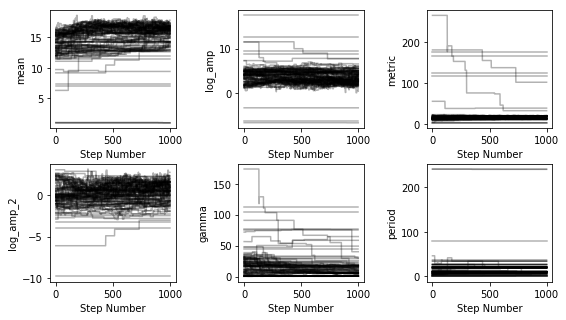

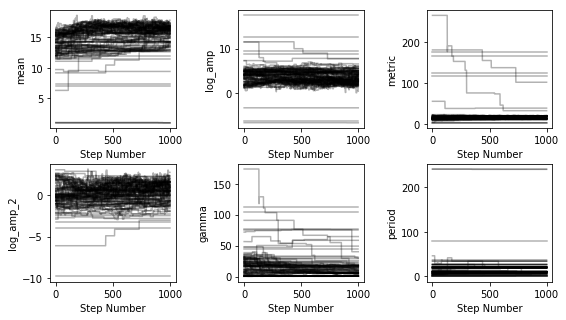

In [22]:
plot_trace(data, 1000)

Trace plot looks decent. Could probably have used a longer burn-in though.

In [5]:
def plot_corner(data, gp, true_period=None, colours=None, zoom=False, trim=None, fig=None, legend=True):
    """
    Plot a corner plot showing the projections of a data set in multi-dimesional space,
    with the different dimensions corresponding to the different kernel parameters.

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    gp :  GP object
        The basic Gaussian Process object.

    true_period : float
        The true period of the asteroid light curves.

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.
        Note, for a corner plot, the first colour will always default to black.
        Only the second true underlying data color can be changed.

    zoom : bool
        Toggles whether the corner plot will show a zoomed in version of the histogram,
        focusing on the densest region of the previous binned histogram.

    trim : [float, float]
        Specifies what percentile range of the period is to be used for plotting.
        This can be used to eliminate extreme outliers that would otherwise distort the plot.

    Returns
    -------

    figure : matplotlib.figure.Figure
        The object with the plot

    """

    if colours == None:
        colours = ["#000000", "#0072B2", "#E69F00", "#009E73", "#F0E442"]

    if trim:

        try:
            lower, upper = np.percentile(data[:,:,-1], [trim[0],trim[1]])
            flat_data = data[(data[:,:,-1]>lower) & (data[:,:,-1]<upper)]

        except TypeError:
            print("ERROR: Values for trim must be formatted as an array (e.g. [5], not 5).\n Plot will be processed without any trimming.")
            flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])

        except IndexError:
            print("WARNING: No upper percentile was specified. Upper percentile was set to 100.")
            trim = np.append(trim, 100)
            lower, upper = np.percentile(data[:,:,-1], [[0],trim[1]])

            flat_data = data[(data[:,:,-1]>lower) & (data[:,:,-1]<upper)]

    else:
        flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])

    if zoom:
        prob, edges = calc_prob(data, period=true_period)

        if prob==0:
            raise Exception('WARNING: Probability around period is 0 and therefore cannot display a valid corner plot.')

        flat_data = data[(data[:,:,-1]>edges[0]) & (data[:,:,-1]<edges[1])]

    #get label names from the gp object
    labels = ['mean', 'log_amp', 'metric', 'log_amp_2', 'gamma', 'period']
    labels[-1] = 'period hours'

    figure = corner.corner(flat_data, labels=labels, show_titles=legend, title_kwargs={"fontsize": 8}, fig=fig)

    return figure

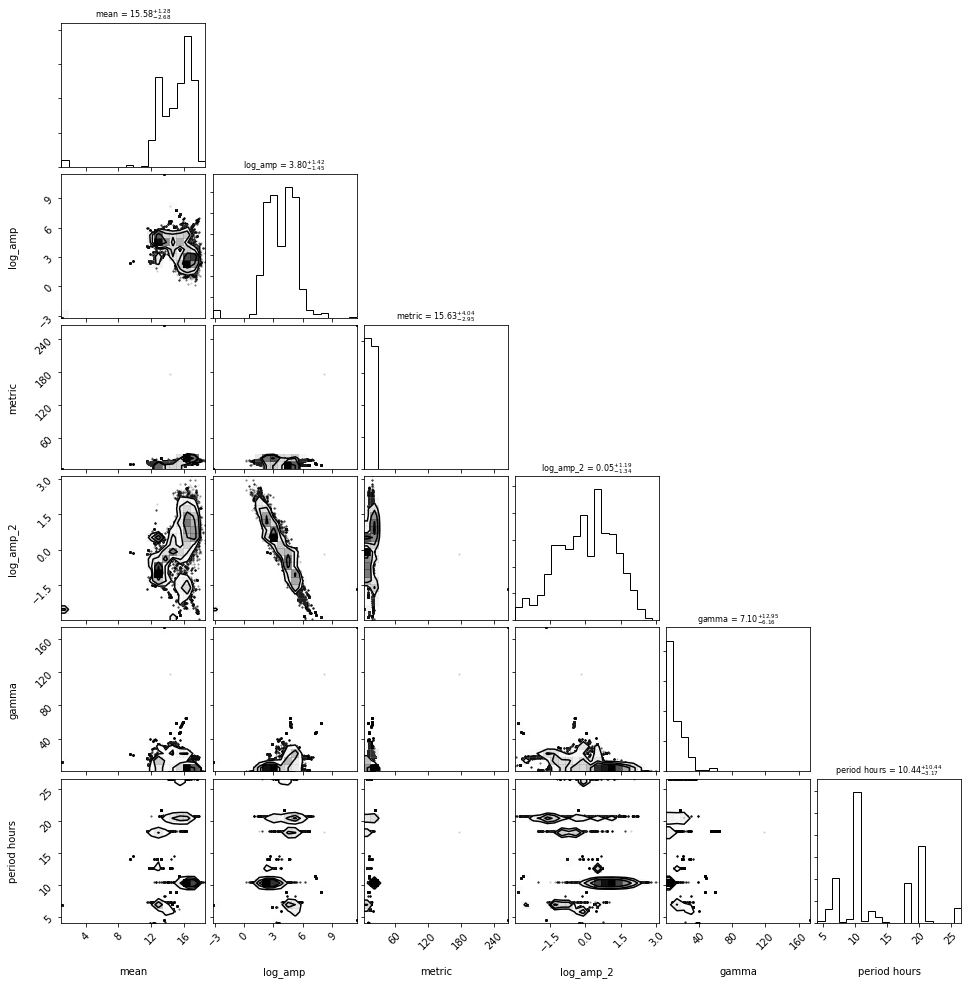

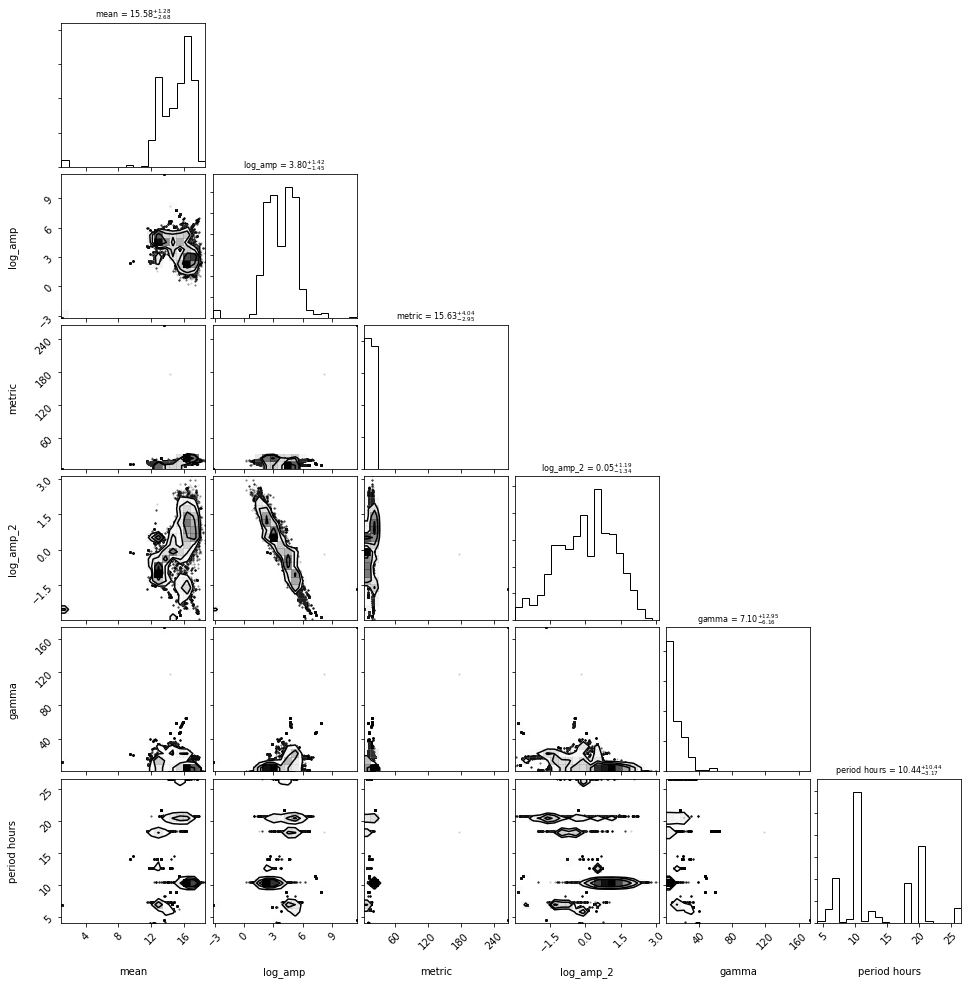

In [24]:
plot_corner(data, gp, trim=[10,90])

Not the greatest looking corner plot. Could probably use a longer run-time.

In [6]:
def plot_posterior(data, true_period=None, legend=True, colours=None):
    """
    Plot a histogram of the posterior distribution, showing the full distribution,
    the 5th-95th percentile of the distribution, and a zoomed-in view of
    the region with the highest probability (or region around the period if specified).

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    true_period : float
        The period (in hours) around which to calculate the probability.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot


    """

    if colours is None:
        colours = ["black", "#0072B2", "#E69F00", "#009E73", "#F0E442"]

    fig, (ax, bx, cx) = plt.subplots(1, 3, figsize=(15,4))

    # plot the full histogram of period results
    flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])

    ax.hist(flat_data[:,-1], bins='auto', density=True, color=colours[0], alpha=0.3)

    if true_period:
        ylim = ax.get_ylim()
        ax.vlines(true_period, 0, ylim[-1], lw=1, color=colours[1], linestyle="dashed", label="true period : %.5f" %true_period)

    ax.set_xlabel("Period in hours")
    ax.set_ylabel("Probability")
    ax.set_ylim(ax.get_ylim())
    ax.set_title("Posteriod Period Distibution")

    # plot the 5th-95th percentile
    lower, upper = np.percentile(data[:,:,-1], [5,95])
    masked_data = data[(data[:,:,-1]>lower) & (data[:,:,-1]<upper)]

    bx.hist(masked_data[:,-1], bins='auto', density=True, color=colours[0], alpha=0.3)

    if true_period:
        ylim = bx.get_ylim()
        bx.vlines(true_period, 0, ylim[-1], lw=1, color=colours[1], linestyle="dashed", label="true period : %.5f" %true_period)

    bx.set_title("5th - 95th Percentile")
    bx.set_xlabel("Period in hours")
    bx.set_ylabel("Probability")
    bx.set_ylim(bx.get_ylim())

    # zoom in on the part of the graph that has the highest probability
    prob, edges = calc_prob(masked_data, true_period, plot=False)

    if prob==0:
            raise Exception('WARNING: Probability around period is 0 and therefore cannot display a valid corner plot.')

    zoom_data = data[(data[:,:,-1]>edges[0]) & (data[:,:,-1]<edges[1])]

    best_period = np.percentile(zoom_data[:,-1], 50)
    
    print(best_period)

    cx.hist(zoom_data[:,-1], bins='auto', density=True, color=colours[0], alpha=0.3)
    ylim = cx.get_ylim()

    if true_period:
        cx.vlines(true_period, 0, ylim[-1], lw=1, color=colours[1], linestyle="dashed", label="true period : %.5f" %true_period)
        cx.vlines(best_period, 0, ylim[-1], lw=1, color=colours[2], linestyle="dashed", label="best period : %.5f" %best_period)
    else:
        cx.vlines(best_period, 0, ylim[-1], lw=1, color=colours[2], linestyle="dashed", label="best period : %.5f" %best_period)
    cx.set_title("Probability %.3f" %prob)
    cx.set_xlabel("Period in hours")
    cx.set_ylabel("Probability")
    cx.set_ylim(ylim)

    if legend:
        ax.legend()
        bx.legend()
        cx.legend()

    plt.tight_layout()
    #plt.savefig(namestr + "_period_pdf.pdf", format="pdf")

    return best_period




In [7]:

def calc_prob(data, period=None, p_range=None, bins=10000, width=0.1, plot=False):
    """
    Calculated the probability of an interval of periods.

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    period : float
        The period (in hours) around which to calculate the probability.

    p_range : list
        List of starting and ending values for an interval.

    bins : int
        The number of bins to calculate with for the numpy histogram. It's best to keep this number very large.

    width : float
        The distance on either side of the period over which will be integrated. Width will be ignored
        if p_range is specified.

    plot : bool, default False
        Returns a plot of the area of the posterior distribution being integrated.

    Returns
    -------

    prob : numpy.float64
        Total integrated area (probability) of the posterior period distribution within the edges listed.

    edges : list
        List of starting and ending values for the interval used to calculate the probability.
        This will be the same as p_range if p_range was specified.

    """

    #flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    flat_data = data
    
    print(flat_data[:,-1])

    h, bins = np.histogram(flat_data[:,-1], bins=bins, density=True, )

    if period:

        edges = [period-width, period+width]
        idx = np.searchsorted(bins, edges, side="left")
        h_i = np.sum(h[idx[0]: idx[1]])


    elif p_range:

        edges = p_range
        idx = np.searchsorted(bins, edges, side="left")
        h_i = np.sum(h[idx[0]: idx[1]])


    else:
        #find the period of hmax
        period = bins[np.abs(h - h.max()).argmin()]
        print(period)

        edges = [period-width, period+width]
        idx = np.searchsorted(bins, edges, side="left")
        h_i = np.sum(h[idx[0]: idx[1]])


    dx = bins[1]-bins[0]

    prob = h_i*dx

    if plot:
        fig, (ax, bx) = plt.subplots(1,2, figsize=(10,5))
        ax.bar(bins[idx[0]: idx[1]], h[idx[0]: idx[1]], width=dx)

        bx.bar(bins[0:-1], h, width=dx)


    return prob, edges

[20.88146203 20.88146203 20.88146203 ... 20.8809849  20.8809849
 20.8809849 ]
10.439676864742815
10.440158801244547


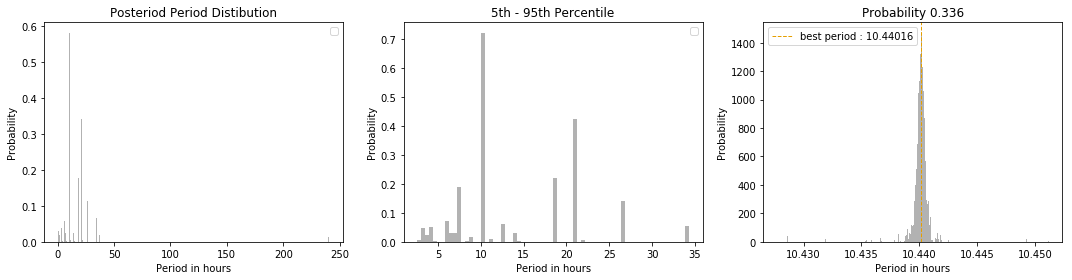

In [27]:
best_period = plot_posterior(data, true_period=None)

The seems to have been some pretty extreme outliers during the MCMC run.

In [35]:
def plot_folded_lightcurve(time, flux, period, flux_err=None, models=None, true_lightcurve=None, ax=None, use_radians=False, legend=True, colours=None):
    """
    Plot a folded periodic light curve, potentially including the true underlying
    model that produced the data (in the case of simulations), or model
    light curves from MCMC.

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    period : float
        The period on which to fold **in hours**

    models : iterable of shape (model_time, numpy.ndarray of shape (nsamples, len(model_time)))
        First element here contains the time stamps for the models (which may not be the same
        as for the data), the second is an array of shape (nsamples, ndatapoints), where nsamples
        is the number of model light curves, and ndatapoints == len(model_time)

    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the
        simulated data was created (could be higher-resolution than the "data"), useful for
        comparison between models created e.g. from MCMC samples and the true underlying process


    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a
        new figure.

    use_radians : bool, default False
        If True, the phase will be plotted from (0, 2pi) instead of (0,1), which is the default.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """

    if colours is None:
        colours = ["#000000", "#0072B2", "#E69F00", "#009E73", "#F0E442"]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))

    period_days = period/24.

    t0 = np.min(time)
    if models:
        t0 = np.min([t0, np.min(models[0])])

    if true_lightcurve:
        t0 = np.min([t0, np.min(true_lightcurve[0])])

    phase = (time-t0)/period_days - np.floor((time-t0)/period_days)

    if use_radians:
        phase *= 2.*np.pi

    if flux_err is None:
        ax.scatter(phase, flux, s=5, color=colours[0], label="Observations")
    else:
        ax.errorbar(phase, flux, yerr=flux_err, fmt="o", c=colours[0], markersize=5, label="Observations")

    if true_lightcurve:
        true_time = (true_lightcurve[0] - t0)
        true_flux = true_lightcurve[1]
        true_phase = true_time/period_days - np.floor(true_time/period_days)

        if use_radians:
            true_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(true_phase)
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]

        # loop through indices where phase goes from 1 (or 2pi) to 0
        # plot each phase light curve separately
        istart = 0
        iend = idx[0]+1

        # first phase cycle also contains the label for the legend
        ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3,
                c=colours[1], label="True Lightcurve")

        for i, x in enumerate(idx[:-1]):
            ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3, c=colours[1], label="")
            istart = x+1
            iend = idx[i+1]+1

        # last plot
        istart = idx[-1]+1
        ax.plot(true_phase[istart:], true_flux[istart:], alpha=0.3, c=colours[1], label="")

    if models:

        m_time = (models[0] - t0)
        m_flux = models[1]

        m_phase = (m_time/period_days) - np.floor(m_time/period_days)
        print("mphase " + str(m_phase))
        if use_radians:
            m_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(m_phase)

        print("tdiff " + str(tdiff))
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]
        #if idx.size == 0:
        #    idx = np.array(0)

        # loop through the different samples
        for i,m in enumerate(m_flux):
            # loop through indices where phase goes from 1 (or 2pi) to 0
            # plot each phase light curve separately
            istart = 0
            iend = idx[0]+1

            if i == 0:
                # first phase cycle also contains the label for the legend
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="model")

            else:
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="")

            for j, x in enumerate(idx[:-1]):
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="")

                istart = x+1
                iend = idx[j+1]+1

            # last plot
            istart = idx[-1]+1
            ax.plot(m_phase[istart:], m[istart:], alpha=0.1, c=colours[2], label="")

    if legend:
        ax.legend()
    ax.set_xlabel("Rotational Phase")
    ax.set_ylabel("Flux")
    ax.set_title(r"period $P = %.5f$"%period)
    if use_radians:
        ax.set_xlim(0, 2*np.pi)
    else:
        ax.set_xlim(0, 1)
    return ax

In [79]:
plot_folded_lightcurve(time, flux, flux_err=flux_err, legend=False,
                                    period=best_period, true_lightcurve=None)#true_lightcurve)

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (120,) and (460830,)

Alright. So we've seen that the kernel can find a good rotational period. Now it's all about figuring out whether the walkers were able to adapt to a new lightcurve profile. In order to test for this, I'm going to single out one walker that settled on the correct period and reconstruct a kernel with its other dimensions.

I'll be using some of the data from the posterior plot to randomly select a walker step.

In [30]:
lower, upper = np.percentile(data[:,:,-1], [5,95])
masked_data = data[(data[:,:,-1]>lower) & (data[:,:,-1]<upper)]


# zoom in on the part of the graph that has the highest probability
prob, edges = calc_prob(masked_data, period=None, plot=False)

zoom_data = data[(data[:,:,-1]>edges[0]) & (data[:,:,-1]<edges[1])]

#best_period = np.percentile(zoom_data[:,-1], 50)

[20.88146203 20.88146203 20.88146203 ... 20.8809849  20.8809849
 20.8809849 ]
10.439676864742815


In [158]:
lower, upper = np.percentile(zoom_data[:,-2], [5,95])
zoom_data_2 = zoom_data[(zoom_data[:,-2]>lower) & (zoom_data[:,-2]<upper)]

In [159]:
lower, upper = np.percentile(zoom_data_2[:,-1], [20,100])
zoom_data_3 = zoom_data_2[(zoom_data_2[:,-1]>lower) & (zoom_data_2[:,-1]<upper)]

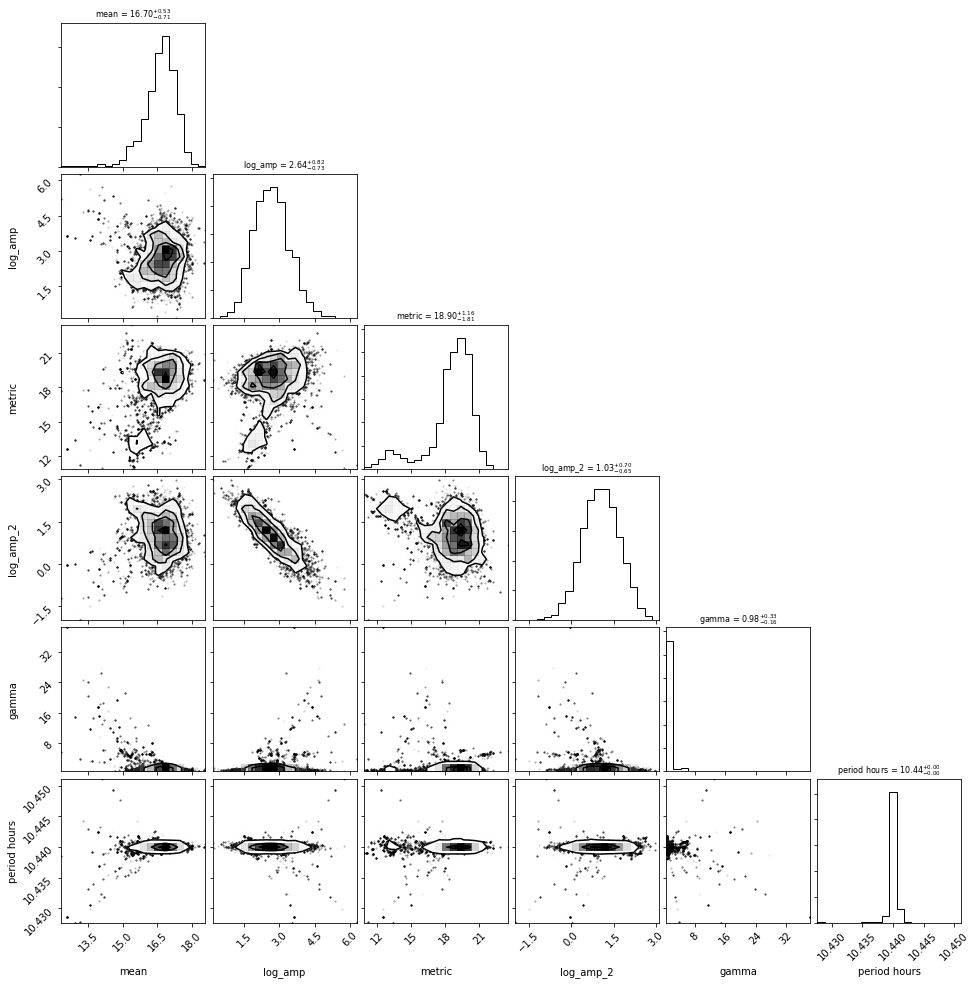

In [31]:
#get label names from the gp object
labels = ['mean', 'log_amp', 'metric', 'log_amp_2', 'gamma', 'period']
labels[-1] = 'period hours'

figure = corner.corner(zoom_data, labels=labels, show_titles=True, title_kwargs={"fontsize": 8}, fig=None)

This level of trimmed data seems like a good selection.

In [161]:
zoom_data_3.shape

(9243, 6)

We can select 5 random steps from this selection of data.

In [180]:
model_params = zoom_data[np.random.randint(0,zoom_data.shape[0],1)]

In [181]:
model_params


array([[17.57527963,  2.41017428, 19.21165216,  1.84395546,  0.98142718,
        10.44042155]])

In [35]:
gp.get_parameter_names()

('mean:value',
 'kernel:k1:k1:log_constant',
 'kernel:k1:k2:metric:log_M_0_0',
 'kernel:k2:k1:log_constant',
 'kernel:k2:k2:gamma',
 'kernel:k2:k2:log_period')

In [192]:
%matplotlib inline

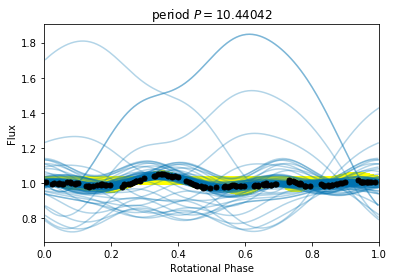

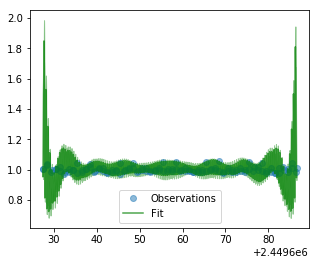

In [193]:
for i in np.arange(len(model_params)):
    # set up a kernel
    k1 = np.exp(model_params[i][1])/10. * george.kernels.ExpSquaredKernel(metric=(model_params[i][2]))
    k2 = np.exp(model_params[i][3])/10. * george.kernels.ExpSine2Kernel(gamma=model_params[i][4], log_period=np.log(model_params[i][5]/24.))

    kernel = k1*k2

    gp = george.GP(kernel, mean=model_params[i][0], fit_mean=True)

    gp.compute(time, flux_err)
    
    pred, pred_var = gp.predict(flux, np.arange(time[0], time[len(time)-1], 0.05/24.), return_var=True)
    pred_time = np.arange(time[0], time[len(time)-1], 0.05/24.)
    
    plot_folded_lightcurve(time, flux, flux_err=flux_err, legend=False,
                                    period=model_params[i][5], true_lightcurve=[pred_time, pred])#true_lightcurve)
    
    plt.figure(figsize=(5, 4))
    plt.plot(time, flux, 'o', alpha=0.5, label="Observations")

    #plot the kernel-fitted guess
    plt.fill_between(pred_time, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="green", alpha=0.4)
    plt.plot(pred_time, pred, 'g', lw=1.5, alpha=0.7, label="Fit")

    plt.legend()

In [187]:
0.45*24

10.8

In [98]:
(0.05/24.)**(-1)

480.0

Okay, so all of these fits look very good. It would be interesting to plot what the first couple of periods look like in comparison to the last couple. We could plot the first 24 hours (480 indices)

In [49]:
len(pred)

28342

In [ ]:
for i in np.arange(len(model_params)):
    # set up a kernel
    k1 = np.exp(model_params[i][1]) * george.kernels.ExpSquaredKernel(metric=(model_params[i][2]))
    k2 = np.exp(model_params[i][3]) * george.kernels.ExpSine2Kernel(gamma=model_params[i][4], log_period=np.log(model_params[i][5]/24.))

    kernel = k1*k2

    gp = george.GP(kernel, mean=model_params[i][0], fit_mean=True)

    gp.compute(time, flux_err)
    
    pred, pred_var = gp.predict(flux, np.arange(time[0], time[len(time)-1], 0.05/24.), return_var=True)
    pred_time = np.arange(time[0], time[len(time)-1], 0.05/24.)
    
    plt.plot(pred_time[0:480], pred[0:480], 'b')
    
    x=0
    
    plt.plot(pred_time[0:480], pred[25342-481: 25342-1], 'orange', label="2 months later")
    plt.plot(time,flux, '.')


In [58]:
480*0.05/24


1.0

This looks strange because now almost 2 months later, it looks like the lightcurve has been completely flipped.

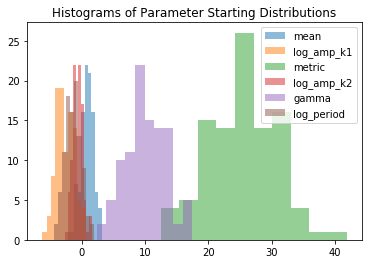

In [204]:
nwalkers = 100

# set up a bunch of kernel starting parameters

mean_flux = np.mean(flux)

# k1
log_amp_k1 = np.log(flux.max()-flux.min())
metric = 5**2

# k2
log_amp_k2 = np.log(0.5)
gamma = 10
log_period = np.log(6/24.)
    

params = {"mean": mean_flux, "log_amp_k1": log_amp_k1, "metric": metric, 
          "log_amp_k2": log_amp_k2, "gamma": gamma,"log_period": log_period}

# Creates a matrix of starting parameters for every walker.
p_start = np.array(list(params.values()))
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=p_start, cov=cov_matrix, size=(nwalkers))

for i in np.arange(len(params)):
    
    plt.hist(p0.T[i], alpha=0.5, label=list(params.keys())[i])
    plt.title("Histograms of Parameter Starting Distributions")
    plt.legend()

# equally distributed starting period values for
p0[:,-1] = np.random.normal(size=nwalkers)*0.5 + np.log(4/24.)

walker_params = p0

"""Calculates initial gp parameter values based on data."""
k1 = np.exp(log_amp_k1) * george.kernels.ExpSquaredKernel(metric=metric)
k2 = np.exp(log_amp_k2) * george.kernels.ExpSine2Kernel(gamma=gamma, log_period=log_period)

kernel = k1*k2

gp = george.GP(kernel, mean=np.mean(flux), fit_mean=True)

gp.compute(time, flux_err)

Let's save this before we accidentally overwrite anything.

In [ ]:
with h5py.File("221_k2*k1_test" + ".hdf5", "w") as f:
    f.create_dataset("chain", data=sampler.chain)

    f.attrs['walkers'] = nwalkers
    f.attrs['iterations'] = 1000 #niter
    f.attrs['data_pts'] = len(flux)
    f.attrs['acceptance_fraction'] = sampler.acceptance_fraction
    #f.attrs['burn_in'] = burn_in
    f.create_dataset("time", data= time)
    f.create_dataset("flux", data = flux)
    f.create_dataset("flux_err", data = flux_err)

# Alright, new day, new plots

In [73]:
filename = "../data/paper_plots/ztf_lightcurves/christina/11397_obs.hdf5"

In [128]:
filename = "../data/paper_plots/221/ztf-lsst/burn_in_10k/221_lc_49627_to_49787.txt_sampled_ztf-lsst_60days.txtprofile_testing.hdf5"

In [74]:
with h5py.File(filename, "r") as f:
        data = f['chain'][:]
        time = f["time"][:]
        flux = f["flux"][:]
        flux_err = f["flux_err"][:]
 #   f.create_dataset("flux", data = flux)
  #  f.create_dataset("flux_err", data = flux_err)


In [75]:
data[:,:,-1] = np.exp(data[:,:,-1])*24.

In [76]:
data[0]

array([[17.54383335,  2.98337094, 18.63749322,  1.1848668 ,  0.17877919,
        21.6808876 ],
       [17.54383335,  2.98337094, 18.63749322,  1.1848668 ,  0.17877919,
        21.6808876 ],
       [17.54383335,  2.98337094, 18.63749322,  1.1848668 ,  0.17877919,
        21.6808876 ],
       ...,
       [17.38258717,  1.68636448, 20.92596242,  2.09058294,  0.25493346,
        15.42351885],
       [17.38258717,  1.68636448, 20.92596242,  2.09058294,  0.25493346,
        15.42351885],
       [17.38258717,  1.68636448, 20.92596242,  2.09058294,  0.25493346,
        15.42351885]])

In [77]:
lower, upper = np.percentile(data[:,:,-1], [5,95])
masked_data = data[(data[:,:,-1]>lower) & (data[:,:,-1]<upper)]


# zoom in on the part of the graph that has the highest probability
prob, edges = calc_prob(masked_data, period=None, plot=False)

zoom_data = data[(data[:,:,-1]>edges[0]) & (data[:,:,-1]<edges[1])]

[21.6808876  21.6808876  21.6808876  ... 23.95002799 23.95002799
 23.95002799]
23.948445914583516


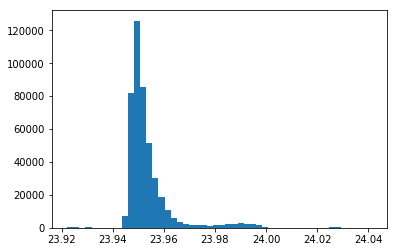

In [78]:
plt.hist(zoom_data[:,-1], bins=50)
plt.show()

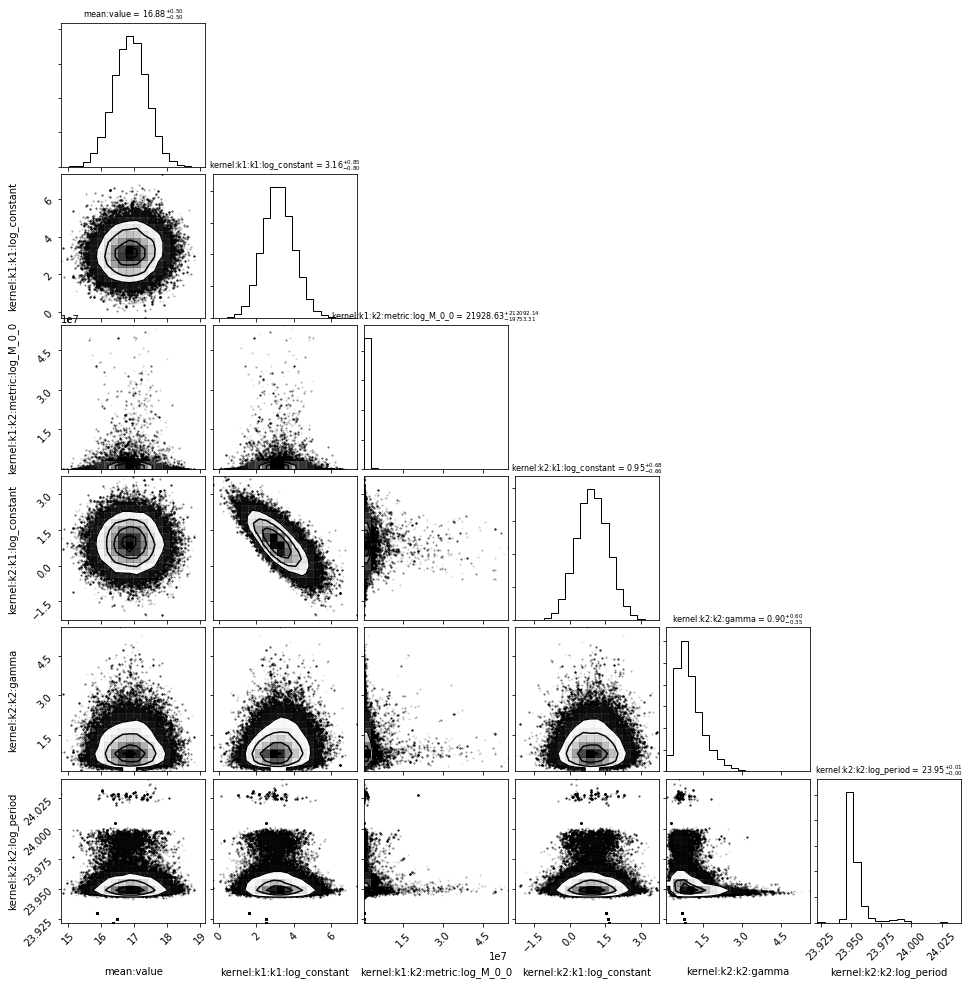

In [79]:
figure = corner.corner(zoom_data, labels=gp.get_parameter_names(), show_titles=True, title_kwargs={"fontsize": 8}, fig=None)

[21.6808876  21.6808876  21.6808876  ... 23.95002799 23.95002799
 23.95002799]
23.948445914583516
23.9509662826298


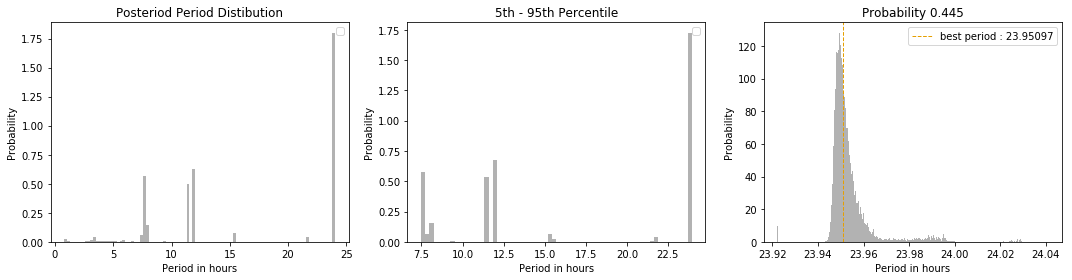

In [80]:
best_period = plot_posterior(data, true_period=None)

In [81]:
i = 0
k1 = np.exp(model_params[i][1]) * george.kernels.ExpSquaredKernel(metric=np.exp(model_params[i][2]))
k2 = np.exp(model_params[i][3]) * george.kernels.ExpSine2Kernel(gamma=model_params[i][4], log_period=np.log(model_params[i][5]/24.))

kernel = k1*k2

gp = george.GP(kernel, mean=model_params[i][0], fit_mean=True)
print(gp.get_parameter_names())

gp.compute(time, flux_err)

pred, pred_var = gp.predict(flux, np.arange(time[0], time[len(time)-1], 0.05/24.), return_var=True)
pred_time = np.arange(time[0], time[len(time)-1], 0.05/24.)

('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')


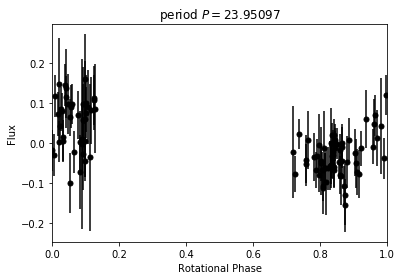

In [82]:
plot_folded_lightcurve(time, flux, flux_err=flux_err, legend=False,
                                    period=best_period)#, true_lightcurve=[pred, pred_time])#true_lightcurve)

('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')
('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')
('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')
('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')
('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')


TypeError: unsupported operand type(s) for %: 'Text' and 'float'

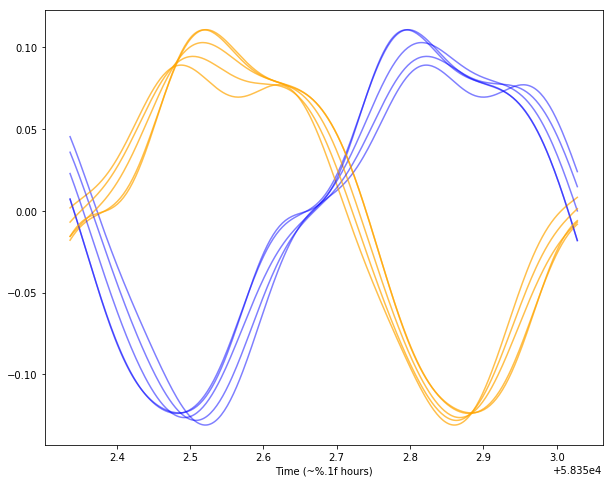

In [64]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

for i in np.arange(len(model_params)):
    # set up a kernel
    ###NOTE! You need to exponentiate the metric value
    k1 = np.exp(model_params[i][1]) * george.kernels.ExpSquaredKernel(metric=np.exp(model_params[i][2]))
    k2 = np.exp(model_params[i][3]) * george.kernels.ExpSine2Kernel(gamma=model_params[i][4], log_period=np.log(model_params[i][5]/24.))

    kernel = k1*k2

    gp = george.GP(kernel, mean=model_params[i][0], fit_mean=True)
    print(gp.get_parameter_names())

    gp.compute(time, flux_err)
    
    pred, pred_var = gp.predict(flux, np.arange(time[0], time[len(time)-1], 0.05/24.), return_var=True)
    pred_time = np.arange(time[0], time[len(time)-1], 0.05/24.)
    
    y=0
    
    if i ==0:
    
        plt.plot(pred_time[0:333], pred[0+y:333+y], 'b', alpha=0.5, label="Kernel: lightcurve")
        x=-25 #fine tuning lineup
        plt.plot(pred_time[0:333], pred[len(pred)-334+x: len(pred)-1+x], 'orange', alpha=0.7, label="Kernel: 2 months later")
        
        
    else:
        plt.plot(pred_time[0:333], pred[0+y:333+y], 'b', alpha=0.5)
        x=-25
        plt.plot(pred_time[0:333], pred[len(pred)-334+x: len(pred)-1+x], 'orange', alpha=0.7)
        
x=-4878 #fine-tuning the peaks to line up
#plt.plot(time_full[0:2000], flux_full[0:2000], label="Real: lightcurve")
#plt.plot(time_full[0:2000], flux_full[172800+x:174800+x], "red", label = "Real: 2 months later")
#plt.plot(time[0:2000], flux[172800*2+x*2:173800*2+x*2], label = "~4 months later")
plt.xlabel("Time (~%.1f hours)") %((pred[len(pred)-1]-pred[0])*24.)
plt.ylabel("Flux")

#plt.plot(time[0:1], flux[0:1], 'k.')
#plt.plot(time[2:4]-(pred_time[333]-pred_time[0]), flux[2:4], 'b.')

plt.legend()
plt.show()


In [67]:
(pred[len(pred)-1])#-pred[0])*24.

0.007653638801716767

In [60]:
model_params = zoom_data[np.random.randint(0,zoom_data.shape[0],5)]

In [61]:
model_params

array([[1.74201895e+01, 2.05496040e+00, 4.46774945e+05, 1.24250046e+00,
        5.48305982e-01, 1.61737781e+01],
       [1.61916060e+01, 1.72347657e+00, 4.37869008e+05, 1.58752252e+00,
        4.99228660e-01, 1.61712031e+01],
       [1.72018733e+01, 3.78928277e+00, 1.17437499e+05, 5.54068725e-01,
        2.62879164e-01, 1.61727893e+01],
       [1.67203493e+01, 3.52583025e+00, 4.85987917e+04, 6.42732931e-01,
        2.85798587e-01, 1.61718859e+01],
       [1.67082009e+01, 3.01313637e+00, 2.57488601e+04, 7.03207418e-01,
        5.52149554e-01, 1.61737836e+01]])

'mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period'

## Add in the full lightcurve

In [167]:
time_full, flux_full= read_data("../data/paper_plots/221/221_lc_49627_to_49787.txt", whitespace=True, error=False)

In [175]:
len(pred)

28342

('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')
('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')
('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')
('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')
('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:gamma', 'kernel:k2:k2:log_period')


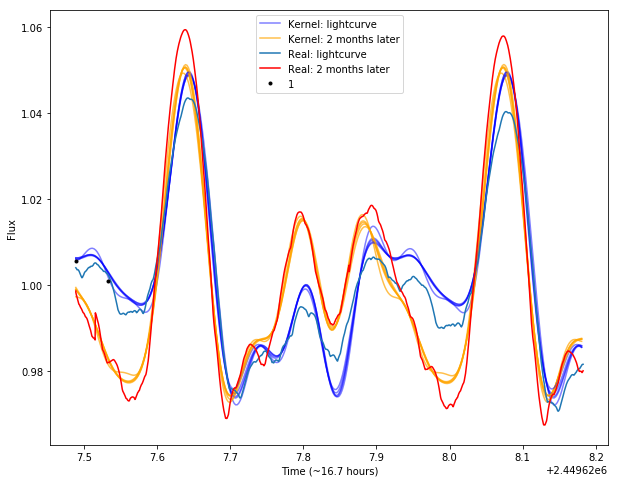

In [285]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

for i in np.arange(len(model_params)):
    # set up a kernel
    ###NOTE! You need to exponentiate the metric value
    k1 = np.exp(model_params[i][1]) * george.kernels.ExpSquaredKernel(metric=np.exp(model_params[i][2]))
    k2 = np.exp(model_params[i][3]) * george.kernels.ExpSine2Kernel(gamma=model_params[i][4], log_period=np.log(model_params[i][5]/24.))

    kernel = k1*k2

    gp = george.GP(kernel, mean=model_params[i][0], fit_mean=True)
    print(gp.get_parameter_names())

    gp.compute(time, flux_err)
    
    pred, pred_var = gp.predict(flux, np.arange(time[0], time[len(time)-1], 0.05/24.), return_var=True)
    pred_time = np.arange(time[0], time[len(time)-1], 0.05/24.)
    
    y=0
    
    if i ==0:
    
        plt.plot(pred_time[0:333], pred[0+y:333+y], 'b', alpha=0.5, label="Kernel: lightcurve")
        x=-25 #fine tuning lineup
        plt.plot(pred_time[0:333], pred[len(pred)-334+x: len(pred)-1+x], 'orange', alpha=0.7, label="Kernel: 2 months later")
        
        
    else:
        plt.plot(pred_time[0:333], pred[0+y:333+y], 'b', alpha=0.5)
        x=-25
        plt.plot(pred_time[0:333], pred[len(pred)-334+x: len(pred)-1+x], 'orange', alpha=0.7)
        
x=-4878 #fine-tuning the peaks to line up
plt.plot(time_full[0:2000], flux_full[0:2000], label="Real: lightcurve")
plt.plot(time_full[0:2000], flux_full[172800+x:174800+x], "red", label = "Real: 2 months later")
#plt.plot(time[0:2000], flux[172800*2+x*2:173800*2+x*2], label = "~4 months later")
plt.xlabel("Time (~%.1f hours)" %((time_full[2000]-time_full[0])*24.))
plt.ylabel("Flux")

plt.plot(time[0:2], flux[0:2], 'k.')
#plt.plot(time[2:4]-(pred_time[333]-pred_time[0]), flux[2:4], 'b.')

plt.legend()
plt.show()


# Let's check to see if the times line up

In [268]:
(pred_time[333] - time_full[2000].max())*24*60

-0.3779279440641403

So the final time is off by 3 minutes. That's fine by me.

In [278]:
x = -4878
(pred_time[len(pred)-334-25: len(pred)-1-25].min() - time_full[172800+x:174800+x].min())*24*60

-0.0035606324672698975

In [234]:
x= 110
time_full[172800+x:174800+x].min()

2449687.518522166

Hmm... There still